In [1]:
from os.path import join
import glob
import numpy as np
from scipy.signal import welch, periodogram
from fooof import FOOOF
from joblib import Parallel, delayed
from tqdm import tqdm
from matplotlib import pyplot as plt

In [2]:
data_dir = "../transformer/data/200/"
result_dir = "../results/fooof"

stages = ["AWA", "AWSL", "NREM", "REM"]
conditions = ["CAF", "PLAC"]

In [3]:
def get_paths(root, subject="*", stage="*", condition="*"):
    return glob.glob(join(root, f"{subject}n*_{stage}_*_{condition}.npy"))

In [4]:
def power_spectrum(x, num_segments=10, frequency=256):
    #return welch(x, fs=frequency, nperseg=len(x) // num_segments, window='hamming')
    return periodogram(x, frequency)

In [5]:
def process_file(path):
    data = np.load(path)
    freqs = None
    result = []
    for elec in range(20):
        try:
            result[elec]
        except IndexError:
            result.append([])
        for idx in range(len(data)):
            f, p = power_spectrum(data[idx,:,elec])
            result[elec].append(p)
            if freqs is None:
                freqs = f
            assert (freqs == f).all()
    return freqs, np.array(result).mean(axis=1).T
            
freqs = None
powers = {}
for stage in stages:
    powers[stage] = {}
    for condition in conditions:
        result = Parallel(n_jobs=-1)(
            delayed(process_file)(path)
            for path in
            tqdm(get_paths(data_dir, stage=stage, condition=condition), desc=f"{stage} {condition}")
        )
        f, p = zip(*result)
        powers[stage][condition] = np.stack(p, axis=0).mean(axis=0)
        freqs = f[0]

REM PLAC: 100%|██████████| 35/35 [00:03<00:00, 11.28it/s]


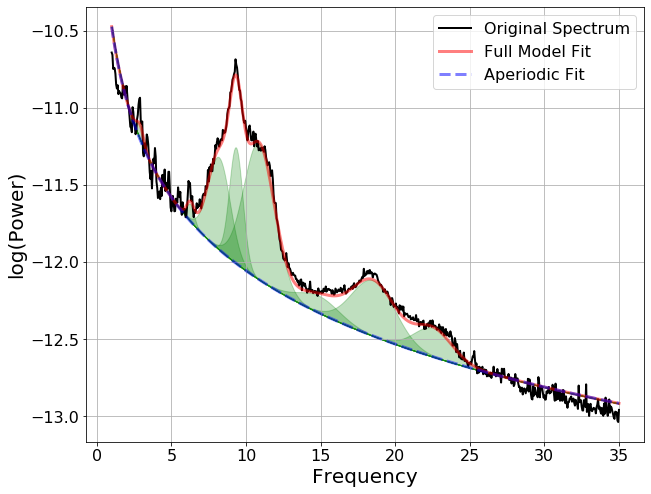

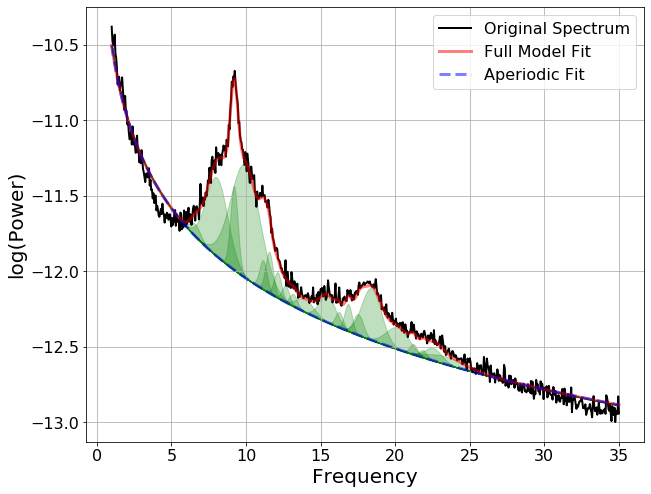

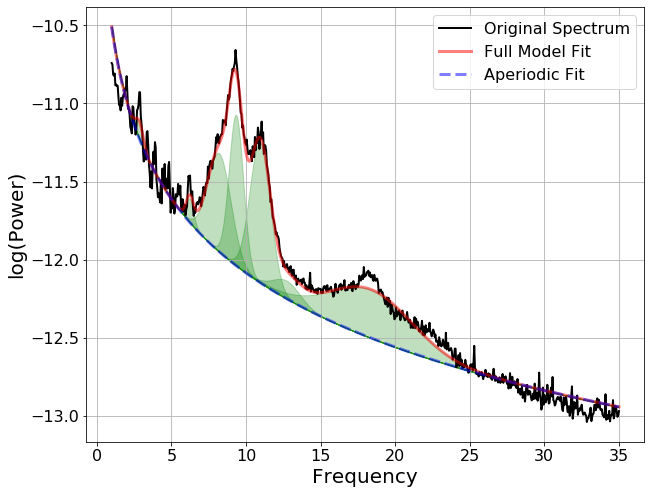

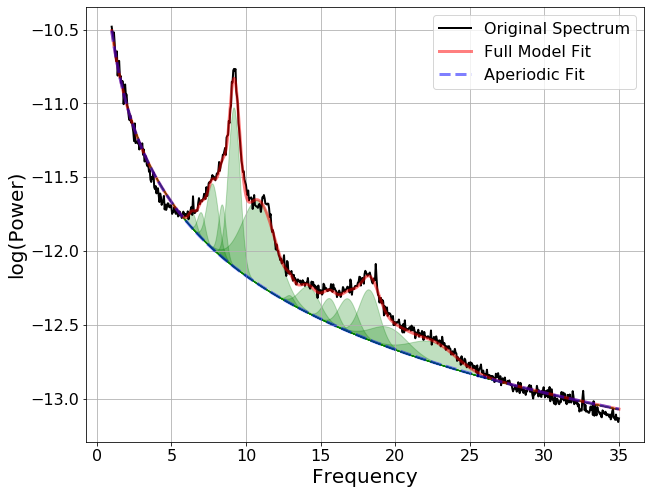

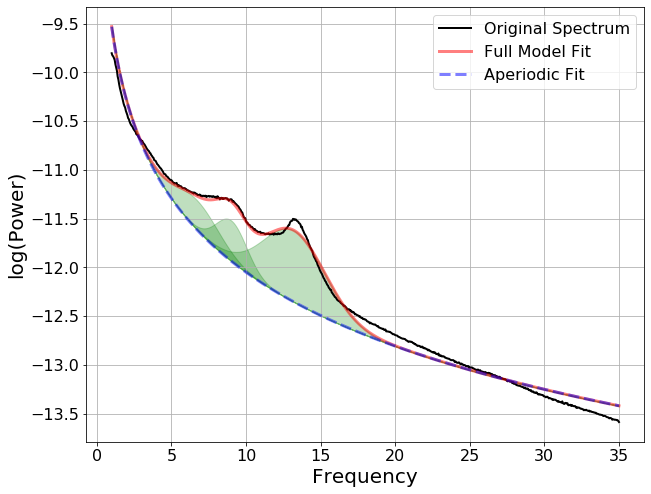

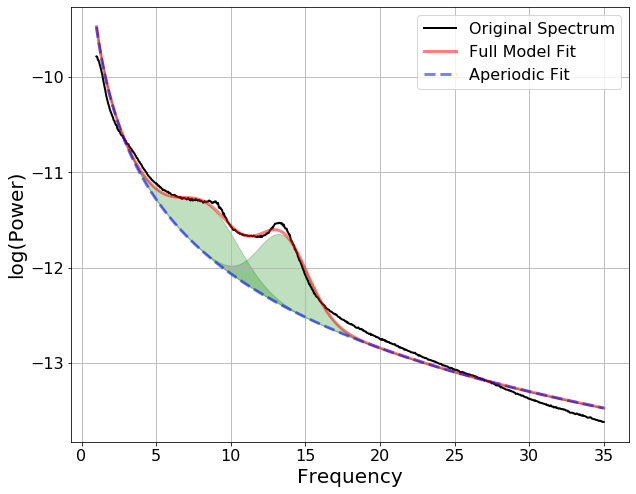

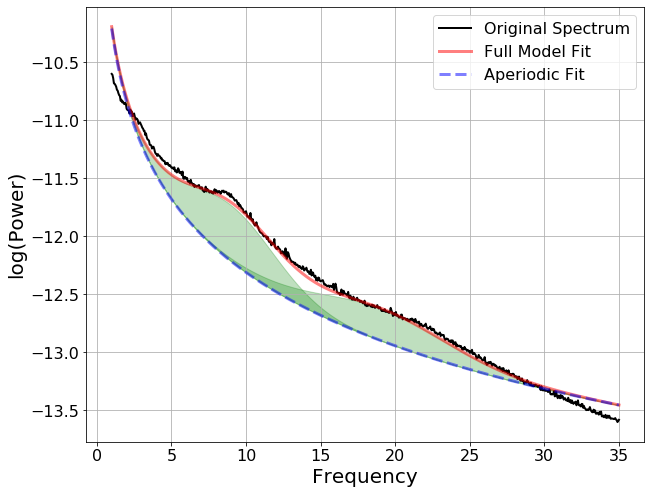

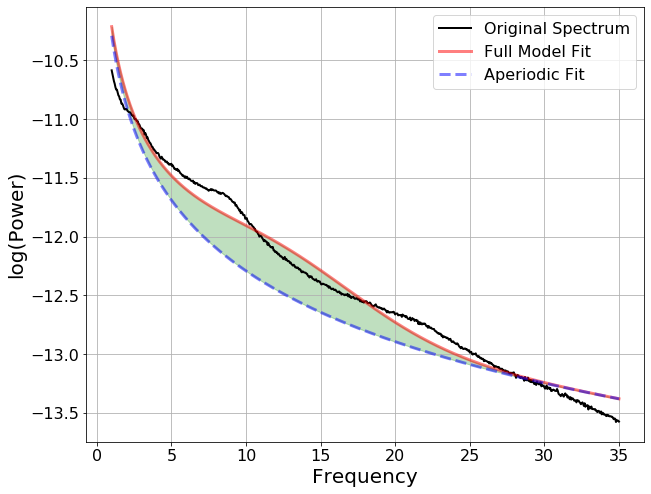

In [6]:
for stage in stages:
    for condition in conditions:
        fm = FOOOF()
        fm.fit(freqs, powers[stage][condition].mean(axis=1), [1, 35])
        fm.plot(plot_peaks='shade', peak_kwargs={'color' : 'green'})
        plt.savefig(join(result_dir, f"fooof-{stage}-{condition}.png"), dpi=300)